In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
import torch.nn as nn
import keras

print(keras.__version__)
print(torch.__version__)

3.1.1
2.2.2+cu121


### Image Encoder

In [3]:
class ConvEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2d_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2d_3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv1d_1 = nn.Conv1d(1024, 256, kernel_size=3, padding=1)
        self.conv1d_2 = nn.Conv1d(256, 128, kernel_size=1)
        self.lstm = nn.LSTM(128, output_dim//2, batch_first=True, bidirectional=True)
        self.batch_norm2d = nn.BatchNorm2d(64)
        self.batch_norm1d = nn.BatchNorm1d(output_dim)
        
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.activation = nn.LeakyReLU()
        self.dropout2d = nn.Dropout2d(p=0.1) # 채널에 대하여 dropout
        self.dropout1d = nn.Dropout1d(p=0.1) # 채널에 대하여 dropout
        
        nn.init.kaiming_normal_(self.conv2d_1.weight)
        nn.init.kaiming_normal_(self.conv2d_2.weight)
        nn.init.kaiming_normal_(self.conv2d_3.weight)
        nn.init.kaiming_normal_(self.conv1d_1.weight)
        nn.init.kaiming_normal_(self.conv1d_2.weight)
        nn.init.xavier_uniform_(self.lstm.weight_ih_l0)
        nn.init.xavier_uniform_(self.lstm.weight_hh_l0)
        
    def forward(self, images):
        # (batch, 3, 64, 512)
        x = self.conv2d_1(images)
        x = self.activation(x)
        x = self.max_pool(x)
        # (batch, 32, 32, 256)
        x = self.conv2d_2(x)
        x = self.activation(x)
        x = self.max_pool(x)
        # (batch, 64, 16, 128)
        x = self.conv2d_3(x)
        x = self.batch_norm2d(x)
        x = self.activation(x)
        x = self.dropout2d(x)
        # (batch, 64, 16, 128)
        x = x.view(x.size(0), -1, x.size(-1))
        # (batch, 1024, 128)
        x = self.conv1d_1(x)
        x = self.conv1d_2(x)
        x = self.batch_norm1d(x)
        x = self.activation(x)
        x = self.dropout1d(x)
        # (batch, 128, 128)
        x = x.transpose(2,1)
        # (batch, 128, 128)
        x, _ = self.lstm(x)
        # (batch, 128, 64*2)
        return x

In [4]:
conv_encoder = ConvEncoder(3, 128).cuda()
z = torch.zeros([16, 3, 64, 512]).cuda()
a = conv_encoder(z)
print(a.shape, a.device)

torch.Size([16, 128, 128]) cuda:0


### Decoder

In [4]:
import numpy as np
import torch.nn.functional as F

class Speller(nn.Module):
    def __init__(self, encoder_dim, target_dim, hidden_dim=128, 
                 sos_id=13, eos_id=14, pad_id=15, max_len=20):
        super().__init__()
        self.rnn_layer = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, num_layers=2, dropout=0.5)
        self.attention = nn.MultiheadAttention(hidden_dim, 4, batch_first=True)
        self.convertor_linear = nn.Linear(encoder_dim, hidden_dim)
        self.output_linear = nn.Linear(hidden_dim*2, target_dim)
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.dropout = nn.Dropout(0.2)
        self.emb = nn.Embedding(16, hidden_dim)
        self.target_dim = target_dim
        self.hidden_dim = hidden_dim
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.pad_id = pad_id
        self.max_len = max_len
        
        nn.init.xavier_uniform_(self.rnn_layer.weight_ih_l0)
        nn.init.xavier_uniform_(self.rnn_layer.weight_hh_l0)
        nn.init.xavier_uniform_(self.rnn_layer.weight_ih_l1)
        nn.init.xavier_uniform_(self.rnn_layer.weight_hh_l1)
        nn.init.xavier_uniform_(self.convertor_linear.weight)
        nn.init.xavier_uniform_(self.output_linear.weight)
        nn.init.xavier_uniform_(self.attention.in_proj_weight)
        nn.init.xavier_uniform_(self.attention.out_proj.weight)
    
    def forward_step(self, rnn_in, converted, hidden_state):
        # rnn_input : (batch, 1, hidden_dim*2)
        # converted : (batch, encoder_seq, hidden_dim)
        # rnn_out : (batch, 1, hidden_dim)
        # context : (batch, 1, hidden_dim)
        # att_score : (batch, 1, encoder_seq)
        # concat_out : (batch, 1, hidden_dim*2)
        # step_out : (batch, 1, target_dim)
        rnn_out, hidden_state = self.rnn_layer(rnn_in, hidden_state)
        context, att_score = self.attention(rnn_out, converted, converted)
        concat_out = torch.cat([rnn_out, context], dim=-1)
        
        x = self.dropout(concat_out)
        x = self.output_linear(x)
        
        step_out = self.logsoftmax(x)
        return step_out, hidden_state, context, att_score

    def beam_search(self, encoder_outputs, beam_size=3):
        device = encoder_outputs.device
        batch_size = encoder_outputs.size(0)
        converted = self.convertor_linear(encoder_outputs).tanh() # (batch, encoder_seq, hidden_dim)
        
        target_idxs = []
        for j in range(batch_size):
            # init
            now_top_score = torch.zeros([1]).to(device) # (n,)
            now_top_idx_all = torch.tensor([self.sos_id], dtype=torch.int64).view(1, 1).to(device) # (n, len)
            idx_last = now_top_idx_all # (n, 1)
            hidden_state = None # (1, n, dim)
            context = converted[j:j+1,0:1,:] # (n, 1, dim)
            
            end_top_idx_all = torch.tensor([], dtype=torch.int64).view(0,1).to(device) # (m, len)
            end_top_score = torch.tensor([]).to(device) # (m,)

            for i in range(self.max_len):
                # forward
                
                # hidden_state : (1, n, dim)
                rnn_in = torch.cat([self.emb(idx_last).tanh(), context], dim=-1) # (n, 1, dim*2)
                converted_j = converted[j:j+1,:,:].tile(idx_last.size(0), 1, 1) # (n, encoder_seq, dim)
                step_out, hidden_state, context, _ = self.forward_step(rnn_in, converted_j, hidden_state)
                # step_out : (n, 1, target_dim)
                # hidden_state : (1, n, dim)
                # context : (n, 1, dim)

                score_last, idx_last = step_out.topk(beam_size) # (n, 1, beam)
                score_last = score_last.transpose(2,0).reshape(-1) # (beam*n,)
                idx_last = idx_last.transpose(2,0).reshape(-1,1) # (beam*n, 1)

                # tile
                candidate_score = now_top_score.tile(beam_size) # (beam*n)
                candidate_idx_all = now_top_idx_all.tile(beam_size, 1) # (beam*n, len)
                candidate_context = context.tile(beam_size, 1, 1) # (beam*n, 1, dim)
                candidate_hidden_state = (hidden_state[0].tile(1, beam_size, 1), 
                                          hidden_state[1].tile(1, beam_size, 1)) # (1, beam*n, dim)
                
                # concat
                candidate_idx_all = torch.cat([candidate_idx_all, idx_last], dim=-1) # (beam*n, len+1)
                pad = torch.tensor(self.pad_id).tile(end_top_idx_all.size(0), 1).to(device)
                end_top_idx_all = torch.cat([end_top_idx_all, pad], dim=-1) # (m, len+1)
                
                # beam*n+m
                candidate_score = (candidate_score*i + score_last)/(i+1)
                candidate_score = torch.cat([candidate_score, end_top_score]) # (beam*n+m)
                candidate_idx_all = torch.cat([candidate_idx_all, end_top_idx_all], dim=0) # (beam*n+m, len+1)

                # get mask
                now_size = idx_last.size(0)
                top_mask = torch.BoolTensor(candidate_score.size(0)).to(device) & False
                end_mask = torch.BoolTensor(candidate_score.size(0)).to(device) & False
                end_mask[now_size:] = True
                end_mask[:now_size] = idx_last.reshape(-1) == self.eos_id
                idx_topk = candidate_score.topk(beam_size)[1]
                top_mask[idx_topk] = True
                
                # select
                end_top_idx_all = candidate_idx_all[end_mask&top_mask, :]
                end_top_score = candidate_score[end_mask&top_mask]
                
                no_end_top_mask = (~end_mask[:now_size]) & top_mask[:now_size]
                now_top_score = candidate_score[:now_size][no_end_top_mask]
                now_top_idx_all = candidate_idx_all[:now_size][no_end_top_mask, :]
                idx_last = idx_last[no_end_top_mask, :]
                hidden_state = (candidate_hidden_state[0][:,no_end_top_mask,:],
                                candidate_hidden_state[1][:,no_end_top_mask,:])
                context = candidate_context[no_end_top_mask,:,:]
                
            score = torch.cat([now_top_score, end_top_score]) # (n+m)
            idx_all = torch.cat([now_top_idx_all, end_top_idx_all], dim=0) # (n+m, len+1)
            best_idx_all = idx_all[score.max(dim=0)[1], 1:] # (1, max_len)
            target_idxs.append(best_idx_all)
            
        target_idxs = torch.stack(target_idxs, dim=0) # (batch, max_len)

        return None, target_idxs, None
    
    def greedy_search(self, encoder_outputs):
        device = encoder_outputs.device
        batch_size = encoder_outputs.size(0)
        converted = self.convertor_linear(encoder_outputs).tanh() # (batch, encoder_seq, hidden_dim)
        
        sos = torch.tensor(self.sos_id).tile(batch_size,1).to(device)
        rnn_in = torch.cat([self.emb(sos).tanh(), converted[:,0:1,:]], dim=-1) # (batch, 1, dim*2)
        hidden_state = None
        
        prob_log_seq = []
        target_idxs = []
        att_recode = []
        
        for i in range(self.max_len):
            step_out, hidden_state, context, att_score = self.forward_step(rnn_in, converted, hidden_state)
            argmax = step_out.max(dim=-1)[1] # (batch, 1)
            rnn_in = torch.cat([self.emb(argmax).tanh(), context], dim=-1) # (batch, 1, hidden_dim*2)
            prob_log_seq.append(step_out) # (batch, 1, target_dim)
            target_idxs.append(argmax)
            att_recode.append(att_score) # (batch, 1, encoder_seq)
            
        prob_log_seq = torch.cat(prob_log_seq, dim=1) # (batch, max_len, dim)
        target_idxs = torch.cat(target_idxs, dim=1) # (batch, max_len)
        att_recode = torch.cat(att_recode, dim=1) # (batch, max_len, encoder_seq)
        
        return prob_log_seq, target_idxs, att_recode
    
    def forward(self, encoder_outputs, target_idxs=None):
        if target_idxs is None:
            return self.greedy_search(encoder_outputs)
        # encoder_outputs : (batch, encoder_seq, encoder_dim)
        # target_idxs : (batch, max_len)
        device = encoder_outputs.device
        batch_size = encoder_outputs.size(0)
        converted = self.convertor_linear(encoder_outputs).tanh() # (batch, encoder_seq, hidden_dim)
        
        sos = torch.tensor(self.sos_id).tile(batch_size,1).to(device)
        rnn_in = torch.cat([self.emb(sos).tanh(), converted[:,0:1,:]], dim=-1) # (batch, 1, dim*2)
        hidden_state = None
        
        prob_log_seq = []
        att_recode = []
        
        for i in range(self.max_len):
            step_out, hidden_state, context, att_score = self.forward_step(rnn_in, converted, hidden_state)
            rnn_in = torch.cat([self.emb(target_idxs[:, i:i+1]).tanh(), context], dim=-1) # (batch, 1, hidden_dim*2)
            prob_log_seq.append(step_out) # (batch, 1, target_dim)
            att_recode.append(att_score) # (batch, 1, encoder_seq)
            
        prob_log_seq = torch.cat(prob_log_seq, dim=1) # (batch, max_len, dim)
        att_recode = torch.cat(att_recode, dim=1) # (batch, max_len, encoder_seq)
            
        return prob_log_seq, target_idxs, att_recode

In [7]:
import numpy as np

encoder_dim, target_dim = 444, 16
speller = Speller(encoder_dim, target_dim).cuda()

encoder_outputs = torch.from_numpy(np.random.randn(4, 128, 444)).float().cuda()
target_inputs = torch.from_numpy(np.random.randint(0, 16, size=[4, 20])).cuda()
pred_seq, _, att_recode = speller(encoder_outputs, target_inputs)
print(pred_seq.shape)
print(att_recode.shape)

torch.Size([4, 20, 16])
torch.Size([4, 20, 128])


In [8]:
encoder_dim = 444
speller = Speller(encoder_dim, target_dim=16)
encoder_outputs = torch.from_numpy(np.random.randn(1, 128, 444)).float()
pred_seq, target_idxs, att_recode = speller(encoder_outputs)
print(pred_seq.shape)
print(target_idxs.shape)
print(att_recode.shape)

torch.Size([1, 20, 16])
torch.Size([1, 20])
torch.Size([1, 20, 128])


In [9]:
encoder_dim = 444
speller = Speller(encoder_dim, target_dim=16)
encoder_outputs = torch.from_numpy(np.random.randn(4, 16, 444)).float()
pred_seq, target_idxs, att_recode = speller.beam_search(encoder_outputs)
# print(pred_seq.shape)
print(target_idxs.shape)
# print(att_recode.shape)

torch.Size([4, 20])


### Model

In [5]:
class ImageLAS(nn.Module):
    def __init__(self, sos_id=13, eos_id=14, pad_id=15, max_len=20):
        super().__init__()
        self.conv_encoder = ConvEncoder(3, 128)
        self.speller = Speller(128, 16, 
                               sos_id=sos_id, eos_id=eos_id, pad_id=pad_id, max_len=max_len)
        
    def forward(self, inputs, target_idxs=None, use_beam=False):
        # inputs : (batch, 3, 64, 512)
        # target : (batch, 20, 16)
        x = self.conv_encoder(inputs)
        # (batch, 128, 128)
        if use_beam: return self.speller.beam_search(x)
        # (batch, 20, 16), (batch, 20), (batch, 20, 128)
        return self.speller(x, target_idxs)

In [11]:
with torch.no_grad():
    img_las = ImageLAS().cuda()
    z = torch.zeros([4, 3, 64, 512]).cuda()
    t = torch.from_numpy(np.random.randint(0, 16, size=[4, 20])).cuda()
    a,b,c = img_las(z)
    print(a.shape,b.shape,c.shape)

torch.Size([4, 20, 16]) torch.Size([4, 20]) torch.Size([4, 20, 128])


In [118]:
model_ = img_las
# 모델의 메모리 사용량 계산
total_params = sum(p.numel() for p in model_.parameters() if p.requires_grad)
model_memory_MB = total_params * 4 / (1024 ** 2)  # 파라미터는 float32 타입이므로 4바이트로 가정

print("Total params :", total_params)
print("Model Memory Usage (MB):", model_memory_MB)

Total params : 1394064
Model Memory Usage (MB): 5.31793212890625


### Data Loader

In [9]:
IMG_DIR = "./dataset/segment/image"
LABEL_DIR = "./dataset/segment/label"
IMG_HEIGHT = 64
MAX_WIDTH = 512
MAX_LENGTH = 20
BATCH_SIZE = 256
SOS_ID, EOS_ID, PAD_ID = 13, 14, 15

In [10]:
from glob import glob
import os

label_paths = sorted(glob(os.path.join(LABEL_DIR, '*.txt')))
labels = []
for path in label_paths:
    with open(path, 'r') as f:
        labels.append(f.read())
char_list = sorted(set(''.join(labels)))
char_list += ['<sos>', '<eos>', '<pad>']
print(f"char_list : {char_list}")
print(f"len : {len(char_list)}")

char_to_num = {c:i for i, c in enumerate(char_list, start=0)}
num_to_char = {i:c for i, c in enumerate(char_list, start=0)}

char_list : ['-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<sos>', '<eos>', '<pad>']
len : 16


In [11]:
from glob import glob
import os

img_paths = []
img_paths += glob(os.path.join(IMG_DIR, '*.jpg'))
img_paths += glob(os.path.join(IMG_DIR, '*.jpeg'))
img_paths += glob(os.path.join(IMG_DIR, '*.png'))
img_paths = sorted(img_paths)
label_paths = sorted(glob(os.path.join(LABEL_DIR, '*.txt')))

print('len(img_paths) :', len(img_paths))
print(len(img_paths) == len(label_paths))

len(img_paths) : 1781
True


In [12]:
# from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import cv2

def read_label(label_path):
    with open(label_path, 'r') as f:
        return f.read()
    
def read_image(path):
    img = cv2.imread(path)[:,:,::-1] # (h,w,3)
    img = cv2.resize(img, [int(img.shape[1]/img.shape[0]*IMG_HEIGHT), IMG_HEIGHT]) # (h,w,3)
    return torch.tensor(img).permute(2,0,1) # (3,h,w)

# 데이터 가져오기
X = list(map(read_image, img_paths))
y = list(map(read_label, label_paths))

# train, valid 분리
X_train_, X_val_, y_train_, y_val_ = train_test_split(X, y, test_size=0.3, random_state=21)

In [13]:
import torchvision.transforms as transforms
import keras.ops as ops
import torch.nn.functional as F

image_transform = transforms.Compose([
    transforms.RandomAffine(0, shear=10),
    transforms.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.5, hue=0.0),
    transforms.RandomPosterize(3),
    transforms.ConvertImageDtype(torch.float32), # 0~1
    transforms.Pad([0,0,MAX_WIDTH,0]),
    transforms.Lambda(lambda x:x[..., :MAX_WIDTH]),
])

image_transform_valid = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32), # 0~1
    transforms.Pad([0,0,MAX_WIDTH,0]),
    transforms.Lambda(lambda x:x[..., :MAX_WIDTH]),
])

label_transform = transforms.Compose([
    transforms.Lambda(lambda x:[char_to_num[c] for c in x]),
    transforms.Lambda(lambda x:x + [EOS_ID] + [PAD_ID]*(MAX_LENGTH-1-len(x))),
    transforms.Lambda(lambda x:torch.tensor(x[:MAX_LENGTH])),
])

In [17]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels, image_transform=None, label_transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.image_transform = image_transform
        self.label_transform = label_transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.image_transform is not None:
            image = self.image_transform(self.images[idx])
        if self.label_transform is not None:
            label = self.label_transform(self.labels[idx])
        return image, label

y_train = torch.stack(list(tqdm(map(label_transform, y_train_), total=len(y_train_))))#.cuda()

train_data = CustomDataset(X_train_, y_train_, image_transform, label_transform)
valid_data = CustomDataset(X_val_, y_val_, image_transform_valid, label_transform)
kwargs = {'batch_size':BATCH_SIZE, 'shuffle':True, 'drop_last':True, 'num_workers':0, 'pin_memory':True}
train_dataloader = DataLoader(train_data, **kwargs)
valid_dataloader = DataLoader(valid_data, **kwargs)

100%|███████████████████████████████████████████████████████████████████████| 1246/1246 [00:00<00:00, 207665.21it/s]


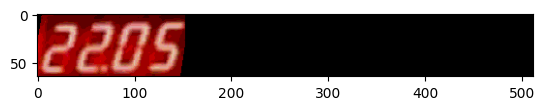

In [21]:
import matplotlib.pyplot as plt

plt.imshow(train_data[15][0].permute(1,2,0).cpu())

### Train

In [12]:
from torch import optim
import numpy as np

# torch.autograd.set_detect_anomaly(True)

EPOCHS = 300

# class weight
_, cnts = np.unique(y_train.reshape(-1).tolist()+[SOS_ID], return_counts=True)
weight = torch.from_numpy(np.log(np.sum(cnts) / cnts)).float().cuda()

# 모델, 손실 함수, 옵티마이저 초기화
model = ImageLAS(sos_id=SOS_ID, eos_id=EOS_ID, pad_id=PAD_ID, max_len=MAX_LENGTH).cuda()
loss_fn = nn.NLLLoss(weight=weight, ignore_index=SOS_ID).cuda() # CrossEntropyLoss().cuda() # (logit, target)
optimizer = optim.AdamW(model.parameters(), lr=0.002)
# scheduler = CosineDecayRestarts(optimizer)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, min_lr=1e-5, patience=20,)

# Early stopping을 위한 변수 초기화
best_val_loss = float('inf')
patience = 50  # 일정 기간 동안 성능이 개선되지 않으면 학습 중지
early_stopping_counter = 0

# history
loss_history = []
val_loss_history = []

# 학습 루틴
for epoch in range(EPOCHS):
    # 학습
    model.train()  # 모델을 학습 모드로 설정
    tra_loss = 0.0
    for inputs, target_idxs in train_dataloader:
    # for inputs, target_idxs in tqdm(train_dataloader, total=len(train_dataloader)):
        inputs, target_idxs = inputs.cuda(), target_idxs.cuda()
        optimizer.zero_grad()  # 그래디언트 초기화
        if 0.9 < np.random.random(): target_idxs = None
        outputs, target_idxs, _ = model(inputs, target_idxs) # 모델 출력 계산
        loss = loss_fn(outputs.permute(0,2,1), target_idxs)  # 손실 계산
        loss.backward()  # 역전파 수행
        optimizer.step()  # 최적화 수행
        tra_loss += loss.item()

    # 검증
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    with torch.no_grad():
        for inputs, target_idxs in valid_dataloader:
            inputs, target_idxs = inputs.cuda(), target_idxs.cuda()
            outputs, _, _ = model(inputs, target_idxs)
            val_loss += loss_fn(outputs.permute(0,2,1), target_idxs).item()  # 검증 손실 누적

    # 출력
    tra_loss /= len(train_dataloader)
    val_loss /= len(valid_dataloader)
    loss_history.append(tra_loss)
    val_loss_history.append(val_loss)
    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1:03d}\tTrain Loss: {tra_loss:.6f}" + 
              f"\tValid Loss: {val_loss:.6f}\tlr: {optimizer.param_groups[0]['lr']:.6f}")

    # 스케줄러에게 현재 검증 손실을 전달하여 학습률 갱신
    scheduler.step(val_loss)
    
    # 검증 손실이 이전보다 크면 early stopping counter를 증가시킴
    if val_loss > best_val_loss:
        early_stopping_counter += 1
    else:
        best_val_loss = val_loss
        early_stopping_counter = 0
        if best_val_loss < 0.35:
            torch.save(model.state_dict(), './models/best.pt')

    # early stopping 조건 충족 시 학습 중지
    if early_stopping_counter >= patience:
        print("Early stopping! No improvement in validation loss.")
        print(f"Epoch {epoch+1:03d}\tTrain Loss: {tra_loss:.6f}" + 
              f"\tValid Loss: {val_loss:.6f}\tlr: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"Best_val_loss : {best_val_loss:.6f}")
        break
    
model = ImageLAS(sos_id=SOS_ID, eos_id=EOS_ID, pad_id=PAD_ID, max_len=MAX_LENGTH)
model.load_state_dict(torch.load('./models/best.pt'))
print("Restored to best model.")

Epoch 005	Train Loss: 1.840529	Valid Loss: 1.900283	lr: 0.002000
Epoch 010	Train Loss: 1.819935	Valid Loss: 1.787448	lr: 0.002000
Epoch 015	Train Loss: 1.661539	Valid Loss: 1.633394	lr: 0.002000
Epoch 020	Train Loss: 1.524960	Valid Loss: 1.512800	lr: 0.002000
Epoch 025	Train Loss: 1.522237	Valid Loss: 1.519181	lr: 0.002000
Epoch 030	Train Loss: 1.264652	Valid Loss: 1.428138	lr: 0.002000
Epoch 035	Train Loss: 1.368829	Valid Loss: 1.401529	lr: 0.002000
Epoch 040	Train Loss: 1.327524	Valid Loss: 1.538412	lr: 0.002000
Epoch 045	Train Loss: 1.211132	Valid Loss: 1.240821	lr: 0.002000
Epoch 050	Train Loss: 1.109415	Valid Loss: 1.092520	lr: 0.002000
Epoch 055	Train Loss: 1.001833	Valid Loss: 1.081420	lr: 0.002000
Epoch 060	Train Loss: 0.900693	Valid Loss: 0.870914	lr: 0.002000
Epoch 065	Train Loss: 0.712311	Valid Loss: 0.831405	lr: 0.002000
Epoch 070	Train Loss: 0.510755	Valid Loss: 0.527275	lr: 0.002000
Epoch 075	Train Loss: 0.469730	Valid Loss: 0.574299	lr: 0.002000
Epoch 080	Train Loss: 0.2

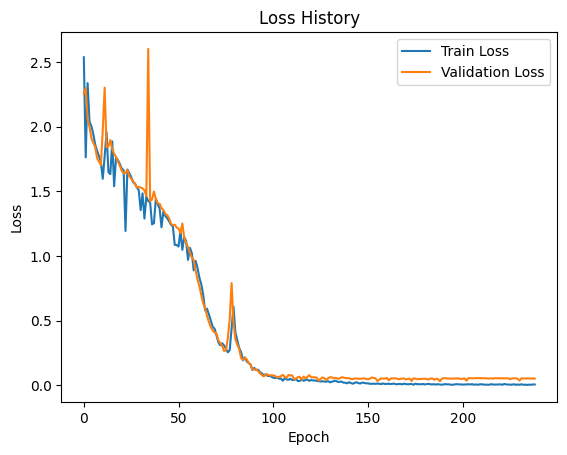

In [14]:
import matplotlib.pyplot as plt

# Loss history 그래프 그리기
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

In [17]:
model_path = './models/LAS_batch_256_dim_128_DA_blstm_0381.pt'
# torch.save(model.state_dict(), model_path)

In [22]:
# model_path = './models/LAS_batch_256_dim_128_DA_blstm_0381.pt'
# model = ImageLAS(sos_id=SOS_ID, eos_id=EOS_ID, pad_id=PAD_ID, max_len=MAX_LENGTH)
# model.load_state_dict(torch.load(model_path))
# model.eval()

ImageLAS(
  (conv_encoder): ConvEncoder(
    (conv2d_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2d_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1d_1): Conv1d(1024, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv1d_2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
    (batch_norm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm1d): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (activation): LeakyReLU(negative_slope=0.01)
    (dropout2d): Dropout2d(p=0.1, inplace=False)
    (dropout1d): Dropout1d(p=0.1, inplace=False)
  )
  (speller): Speller(
    (rnn_layer): LSTM(256, 128, num_layers

### Inference

In [17]:
from torchvision import transforms
import torch
import cv2

class InferenceModel:
    def __init__(self, model_path, sos_id=13, eos_id=14, pad_id=15, 
                 max_len=20, img_h=64, max_img_w=512, device='cpu'):
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.pad_id = pad_id
        self.max_len = max_len
        self.img_h = img_h
        self.max_img_w = max_img_w
        self.device = device
        self.model = self.load_model(model_path)
        self.image_transform = transforms.Compose([
            transforms.ConvertImageDtype(torch.float32), # 0~1
            transforms.Pad([0,0,self.max_img_w,0]),
            transforms.Lambda(lambda x:x[..., :self.max_img_w]),
        ])
    
    def load_model(self, path):
        model = ImageLAS(sos_id=self.sos_id, eos_id=self.eos_id, pad_id=self.pad_id, max_len=self.max_len)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model.to(self.device)
    
    def read_image(self, path):
        img = cv2.imread(path)[:,:,::-1] # (h,w,3)
        img = cv2.resize(img, [int(img.shape[1]/img.shape[0]*self.img_h), self.img_h]) # (h,w,3)
        return torch.tensor(img).permute(2,0,1) # (3,h,w)
    
    def __call__(self, img_ndarr_uint8, channel_first=False, is_bgr=False, use_beam=False):
        assert type(img_ndarr_uint8) is np.ndarray
        assert img_ndarr_uint8.dtype == np.uint8
        
        img = img_ndarr_uint8
        if channel_first: img = np.transpose(img, axes=(1, 2, 0))
        if is_bgr: img = img[..., ::-1]
        
        img = cv2.resize(img, [int(img.shape[1]/img.shape[0]*self.img_h), self.img_h]) # (h,w,3)
        img = torch.tensor(img).permute(2,0,1).to(self.device)
        
        img = self.image_transform(img).unsqueeze(0)
        with torch.no_grad():
            _, y, att_score = self.model(img, use_beam=use_beam)
        idx_seq = y.tolist()[0]
        ch_seq = list(map(lambda x:num_to_char[x], idx_seq))
        string = ''.join(ch_seq).split('<eos>')[0]
        return string, att_score

In [18]:
model_path = './models/LAS_batch_256_dim_128_DA_blstm_0381.pt'
inference_model = InferenceModel(model_path)

23:57:59


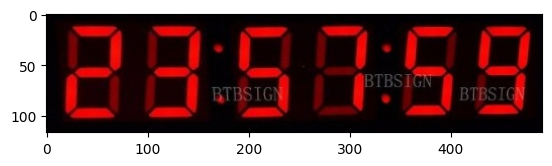

In [19]:
import cv2
img = cv2.imread(img_paths[9])
s, _ = inference_model(img, is_bgr=True, use_beam=True)
print(s)

import matplotlib.pyplot as plt
plt.imshow(img[...,::-1])

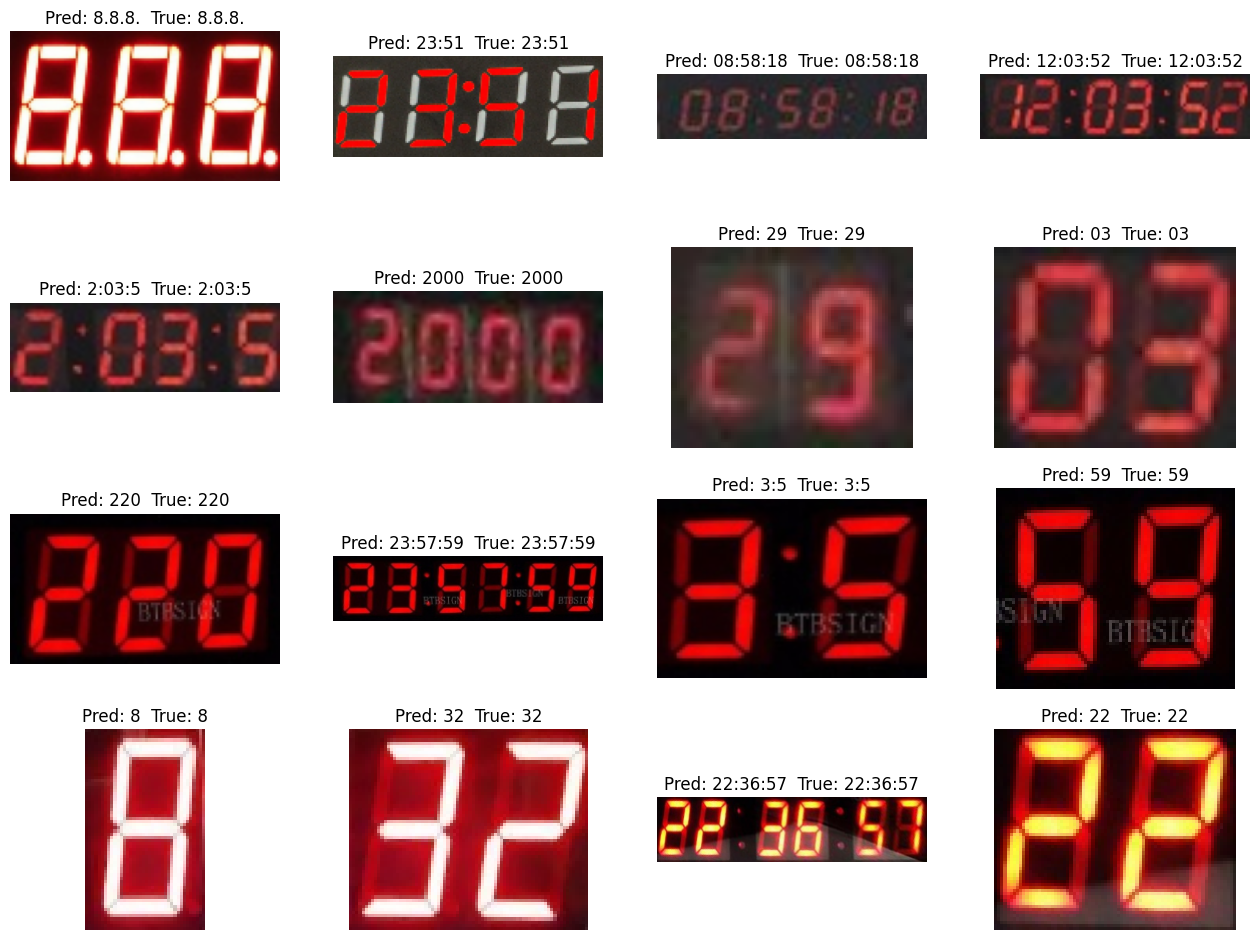

In [129]:
import matplotlib.pyplot as plt
import cv2

_, ax = plt.subplots(4, 4, figsize=(16, 12))

for i, (img_path, label_path) in enumerate(zip(img_paths[:16], label_paths[:16])):
    img = cv2.imread(img_path)
    with open(label_path, 'r') as f:
        label = f.read()
    
    s, att = inference_model(img, is_bgr=True, use_beam=True)
    
    img = cv2.resize(img, [int(img.shape[1]/img.shape[0]*64), 64])[..., ::-1]
    
    title = f"Pred: {s}  True: {label}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
        
# plt.savefig('./temp/savef_plt.jpg')
plt.show()

In [148]:
import numpy as np

img = cv2.imread(img_paths[9])
s, att = inference_model(img, is_bgr=True, use_beam=False)
img = cv2.resize(img, [int(img.shape[1]/img.shape[0]*64), 64])[..., ::-1]
zero = np.zeros([IMG_HEIGHT, MAX_WIDTH, 3], dtype=np.uint8)
zero[:, :img.shape[1], :] = img
img = zero

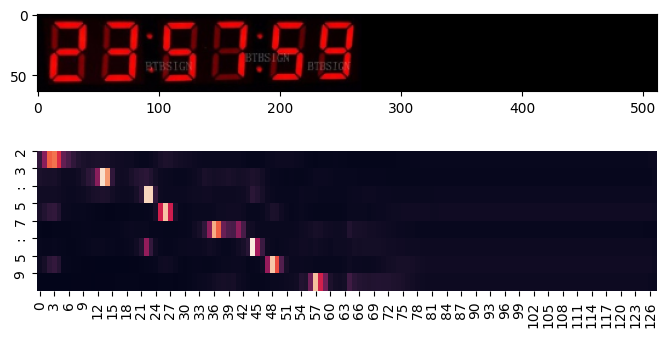

In [164]:
import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(img)
ax[1] = sns.heatmap(att[0][:len(s),:], cbar=False)
ax[1].set_yticks(range(len(s)), list(s))